In [1]:
import time
import re
import random
random.seed(2016)

import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn import linear_model
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import pipeline, grid_search
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, make_scorer

In [8]:
def fmean_squared_error(ground_truth, predictions):
    fmean_squared_error_ = mean_squared_error(ground_truth, predictions)**0.5
    return fmean_squared_error_

In [27]:
loc = '%s'
#loc = '/home/ec2-user/data/hd/features/%s'
a_o = np.load(loc % 'train_data.npy')
b_o = np.load(loc % 'test_data.npy')
a_brand = np.load(loc % 'features_brand_01_train.npy')
b_brand = np.load(loc % 'features_brand_01_test.npy')
a_other = np.load(loc % 'FEATURES_1d_TRAIN.npy')
b_other = np.load(loc % 'FEATURES_1d_TEST.npy')
a_word_feat = np.load(loc % 'SPECIAL_WORDS_FEAT_TRAIN.npy')
b_word_feat = np.load(loc % 'SPECIAL_WORDS_FEAT_TEST.npy')

a_w2vdot = pd.read_pickle(loc % 'W2V_dots_train.df').drop('relevance', axis=1).values
b_w2vdot = pd.read_pickle(loc % 'W2V_dots_test.df').drop('relevance', axis=1).values

a_w2vdist = np.load(loc % 'W2V_dists_train.npz')['arr_0']
b_w2vdist = np.load(loc % 'W2V_dists_test.npz')['arr_0']

a_w2v_el = np.load(loc % 'W2V_vecs_train.npz')['arr_0']
b_w2v_el = np.load(loc % 'W2V_vecs_test.npz')['arr_0']

In [60]:
a = np.hstack((a_o, a_brand, a_other, a_w2vdot, a_word_feat, a_w2vdist)) #, a_w2v_el))
b = np.hstack((b_o, b_brand, b_other, b_w2vdot, b_word_feat, b_w2vdist)) #, b_w2v_el))

In [61]:
idx_train = pd.read_pickle(loc % 'LABELS_TRAIN.df')
idx_test = pd.read_pickle(loc % 'LABELS_TEST.df')

validation_idx = pd.read_csv(loc % 'valid_set.csv.gz', index_col= 'id').index
train_idx = idx_train.index.difference(validation_idx)

df_a = pd.DataFrame(a, index=idx_train.index)

train_idx.shape, validation_idx.shape

((53907,), (20160,))

In [62]:
df_training_alex = df_a.loc[train_idx]
df_validating_alex = df_a.loc[validation_idx]

df_training_alex_label = idx_train.loc[train_idx]
df_validating_alex_label = idx_train.loc[validation_idx]

In [31]:
#   TRACK A
# without "co-occurring 6" features, and only limited number of features
X_train = df_training_alex.values[:, 0:100]
y_train = df_training_alex_label.values

X_test = df_validating_alex.values[:, 0:100]
y_test = df_validating_alex_label.values

X_train.shape, y_train.shape,  X_test.shape, y_test.shape

((53907, 100), (53907, 1), (20160, 100), (20160, 1))

In [63]:
#   TRACK B
# without "co-occurring 6" features
X_train = df_training_alex.values
y_train = df_training_alex_label.values

X_test = df_validating_alex.values
y_test = df_validating_alex_label.values

X_train.shape, y_train.shape,  X_test.shape, y_test.shape

((53907, 272), (53907, 1), (20160, 272), (20160, 1))

In [78]:
#   TRACK C
# with "co-occurring 6" features

coo_tra = pd.read_csv(loc % 'word_co_train_local.csv.gz', index_col='id')
coo_val = pd.read_csv(loc % 'word_co_validate_local.csv.gz', index_col='id')

X_train = np.hstack((df_training_alex.values, coo_tra.values))
y_train = df_training_alex_label.values

X_test = np.hstack((df_validating_alex.values, coo_val.values))
y_test = df_validating_alex_label.values

X_train.shape, y_train.shape,  X_test.shape, y_test.shape

((53907, 278), (53907, 1), (20160, 278), (20160, 1))

In [65]:
clf = linear_model.Ridge (alpha = 0.6)
clf.fit(X_train, y_train)
y_hat = clf.predict(X_test)
y_hat = np.minimum(np.maximum(y_hat, 1.0), 3.0)
fmean_squared_error(y_hat, y_test)

#0.47733228483742429
# 0.47327677738827956
# 0.4674938702127619

0.46855983499315912

In [81]:
aas = []
for i in range(150, 280):
    X_train1 = X_train[:, 0:i]
    y_train1 = y_train

    X_test1 = X_test[:, 0:i]
    y_test1 = y_test

    clf = linear_model.Ridge (alpha = 0.6)
    clf.fit(X_train1, y_train1)
    y_hat = clf.predict(X_test1)
    y_hat = np.minimum(np.maximum(y_hat, 1.0), 3.0)
    aas.append((i,fmean_squared_error(y_hat, y_test)))

In [75]:
aas

[(260, 0.47649325449733348),
 (261, 0.47646237592355173),
 (262, 0.47642584348415734),
 (263, 0.47636281303789491),
 (264, 0.47636362460353404),
 (265, 0.47634629974654935),
 (266, 0.47633207031469571),
 (267, 0.47634278706587102),
 (268, 0.47633912105830378),
 (269, 0.47632655882051261),
 (270, 0.47630090841251516),
 (271, 0.47610981376825984),
 (272, 0.4761270357149654),
 (273, 0.47351702100669979),
 (274, 0.47178761585910944),
 (275, 0.4692805133198405),
 (276, 0.46906775880156804),
 (277, 0.468914481369409),
 (278, 0.46855983499315912),
 (279, 0.46855983499315912)]

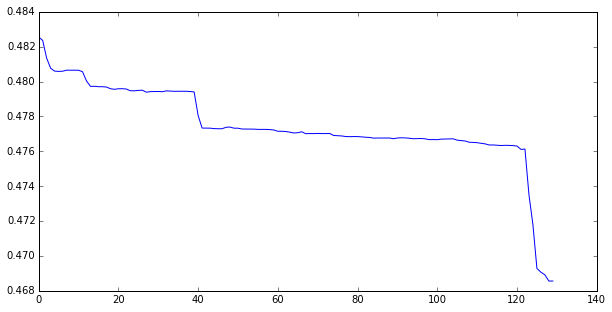

In [82]:
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

plt.plot([x[1] for x in aas])
plt.show()

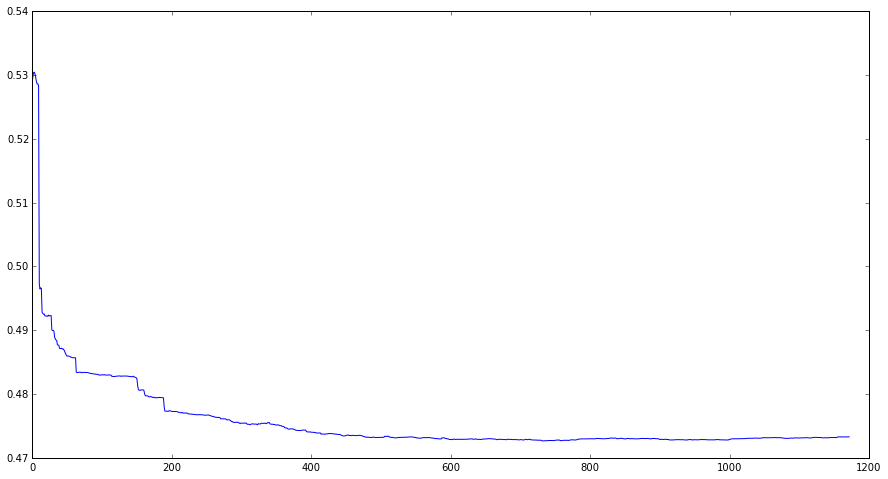

In [34]:
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 15, 8

plt.plot(aas)
plt.show()

In [36]:
first_1172 = aas
pd.DataFrame(aas)

,0
0,0.528935
1,0.529975
2,0.530451
3,0.530449
4,0.530124
5,0.529517
6,0.528955
7,0.528607
8,0.528630
9,0.528360


In [42]:
coo_tra.shape, coo_val.shape

((53907, 7), (20160, 8))

In [44]:
coo_tra
coo_val

,relevance,orig_rel,woqt1,woqt2,woqt3,woqt4,woqt5,woqt6
0,-1,3.00,0.054131,0.139973,0.017308,0.033680,0.084147,0.010375
1,-1,2.33,0.101627,0.259178,0.012521,0.081595,0.214880,0.014222
2,-1,3.00,0.206146,1.042023,0.161459,0.010576,0.050057,0.007427
3,-1,3.00,0.250737,0.654225,0.064001,0.181117,0.467228,0.040137
4,-1,1.00,0.020699,0.052253,0.003647,0.023631,0.042638,0.000358
5,-1,1.33,0.020683,0.054795,0.001254,0.036444,0.118722,0.000749
6,-1,2.00,0.025676,0.090455,0.001537,0.011935,0.035702,0.000550
7,-1,2.67,0.111331,0.442529,0.000667,0.010946,0.034239,0.000162
8,-1,3.00,0.077544,0.163294,0.000314,0.127381,0.194105,0.000086
9,-1,2.00,0.139412,0.254918,0.022218,0.136884,0.201258,0.031163


In [22]:
a.shape, X_train.shape, y_test.shape

((74067, 191), (53907, 190), (20160, 1))

### Checked LR

In [ ]:
def next_num_round():
    return np.random.randint(750, 950)

num_round = 10000

# TRAIN AS SELF
param = {'max_depth':9, 
         'eta':0.1, # 'objective':'reg:linear',
         'eval_metric':'rmse', #'maximize': False,
         'colsample_bytree':0.3,
         'subsample':0.9,
         'nthread':8,
         'silent': True
        }
# GOOD <<
param = {'max_depth':7, 
         'eta':0.03, # 'objective':'reg:linear',
         'eval_metric':'rmse', #'maximize': False,
         'colsample_bytree':0.7, #7
         'subsample':0.9,  #8
         'min_child_weight': 4.0,
         'nthread':32,
         'silent': True
        }
param = {'max_depth':9, 
     'eta':0.01, # 'objective':'reg:linear',
     'eval_metric':'rmse', #'maximize': False,
     'colsample_bytree':0.7, #7
     'subsample':0.9,  #8
     'min_child_weight': 4.0,
     'nthread':32,
     'silent': True
    }
param = {'max_depth':6, 
     'eta':0.01, # 'objective':'reg:linear',
     'eval_metric':'rmse', #'maximize': False,
     'colsample_bytree':0.6, #7
     'subsample':0.8,  #8
     'min_child_weight': 5.0,
     'nthread':32,
     'silent': True,
     'seed': 37
    }

param = {'max_depth':7, 
     'eta':0.01, # 'objective':'reg:linear',
     'eval_metric':'rmse', #'maximize': False,
     'colsample_bytree':0.6, #7
     'subsample':0.8,  #8
     'min_child_weight': 5.0,
     'nthread':32,
     'silent': True,
     'seed': 39
    }

num_round = 200000
bst = xgb.train( param, gX_train, num_round, [(gX_train,'train'),(gX_test,'test')], early_stopping_rounds=100, verbose_eval=10)
#bst = xgb.train( param, gX_train, num_round, [(gX_train,'train'),(gX_test,'test')], verbose_eval=10)

In [ ]:
# 700x trees  -  cv: 0.4377 (seed 147)
param = {'max_depth':9, 
         'eta':0.01, # 'objective':'reg:linear',
         'eval_metric':'rmse', #'maximize': False,
         'colsample_bytree':0.3, #0.8 #7  0.4449
         'subsample':0.8, #0.9,  #8
         'min_child_weight': 4.0,
         'nthread':32,
         'silent': True
        }  
num_round = 5000
bst = xgb.train( param, gX_train, num_round, [(gX_train,'train'),(gX_test,'test')], early_stopping_rounds=30, verbose_eval=10)

In [ ]:
ggX_train = xgb.DMatrix(data=a_full, label=dtrain.get_label())
ggX_test = xgb.DMatrix(data=b_full)

idx_train = pd.read_pickle(loc % 'LABELS_TRAIN.df')
idx_test = pd.read_pickle(loc % 'LABELS_TEST.df')

num_round = 1550
bst = xgb.train( param, ggX_train, num_round, [(gX_test,'test')], verbose_eval=50)

y_pred = bst.predict(ggX_test)
y_pred_bounded = np.minimum(np.maximum(y_pred, 1.0), 3.0)
idx_test['relevance'] = y_pred_bounded
idx_test.to_csv('submission_RenatPawel_combined_features_xgboost_0408_0137.csv')

In [ ]:
!gzip submission_xgboost_words_0405_1646.csv

In [ ]:
# 1500 trees 
param = {'max_depth':9, 
         'eta':0.01, # 'objective':'reg:linear',
         'eval_metric':'rmse', #'maximize': False,
         'colsample_bytree':0.8, #0.8 #7  0.4449
         'subsample':0.9, #0.9,  #8
         'min_child_weight': 4.0,
         'nthread':32,
         'silent': True
        }  
num_round = 5000
bst = xgb.train( param, gX_train, num_round, [(gX_train,'train'),(gX_test,'test')], early_stopping_rounds=15, verbose_eval=10)

with 0.30 and 1479
cv:  0.4493

In [ ]:
loc = '%s'

aaa = pd.read_pickle(loc % 'WOQTAL_TRAIN_ALL')
bbb = pd.read_pickle(loc % 'WOQTAL_TEST_ALL')


In [ ]:
aaa.head()

In [ ]:
aaa[aaa['woqt1'] > 0.127]['relevance'].mean(), aaa[aaa['woqt1'] < 0.127]['relevance'].mean()

In [ ]:
aaa[aaa['woqt2'] > 0.329895]['relevance'].mean(), aaa[aaa['woqt2'] < 0.329895]['relevance'].mean()

In [ ]:
aaa['woqt2'].mean()

In [ ]:
bbb.head()

In [ ]:
aa = aaa.drop('relevance', axis=1)
bb = bbb.drop('relevance', axis=1)

In [ ]:
aa.reset_index().to_csv('word_co_train.csv', header=True, index=False)

In [ ]:
#bb.reset_index().to_csv('word_co_test.csv', header=True, index=False)

In [49]:
#coo_tra = pd.read_csv(loc % 'word_co_train_local.csv.gz')
#coo_val = pd.read_csv(loc % 'word_co_validate_local.csv.gz')
coo_tra = pd.read_csv(loc % 'word_co_train_local.csv.gz', index_col='id').drop('relevance', axis=1)
coo_val = pd.read_csv(loc % 'word_co_validate_local.csv.gz', index_col='id').drop('orig_rel', axis=1)


In [56]:
coo_tra = pd.read_csv(loc % 'word_co_train_local.csv.gz').drop('relevance', axis=1)
coo_val = pd.read_csv(loc % 'word_co_validate_local.csv.gz').drop('orig_rel', axis=1)

#coo_tra.to_csv('word_co_train_local.csv', index=False)
#coo_val.to_csv('word_co_validate_local.csv', index=False)